# Table of Contents

1. Data Loading
2. Data Preprocessing
3. Model Loading 
4. Model Fine Tuning
5. Model Training
6. Evaluation

# Data Loading

In [1]:
import pandas as pd
import numpy as np

# Data Preprocessing

In [2]:
df = pd.read_csv("data/final.csv", encoding="ISO-8859-1", index_col=0)

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from script.text_cleaning import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\likah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [5]:
preprocessed_df = text_preprocess(df,'text')
preprocessed_df.head()

,text,spam
0,dear homeowner interest rates lowest point 40 ...,1
1,help wanted we 14 year old fortune 500 company...,1
2,subject ua 4 meter 8608 6 98 deal 96731 daren ...,0
3,subject fw pymt 03 01 sales adjustment cowtrap...,0
4,sean o donnell wrote doesnt answer question th...,0


In [6]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.spam)

In [7]:
max_len = 50

# Model Loading

In [8]:
from transformers import RobertaTokenizer, TFRobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [9]:
X_train = tokenizer(text=train_df.text.tolist(),
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)
X_test = tokenizer(text=test_df.text.tolist(),
                  max_length=max_len,
                  padding='max_length',
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

In [10]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

# Model Fine Tuning

In [11]:
embeddings = model(input_ids,attention_mask=attention_mask)[0]
output = Flatten()(embeddings)
output = Dense(2, activation='sigmoid')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

In [12]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [13]:
# tf.config.run_functions_eagerly(True)

# Model Training

In [14]:
checkpoint_filepath = 'model/roberta_base'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_balanced_accuracy',
    mode='max',
    save_best_only=True)

# model = tf.keras.models.load_model('saved_model/roberta_checkpoint')

In [15]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.spam),
              epochs=5,
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.spam)),
              callbacks = [model_checkpoint_callback]
             )

Epoch 1/5
132/132 [==============================] - ETA: 0s - loss: 0.2822 - balanced_accuracy: 0.8757 

INFO:tensorflow:Assets written to: model\roberta_base\assets


INFO:tensorflow:Assets written to: model\roberta_base\assets


132/132 [==============================] - 2176s 16s/step - loss: 0.2822 - balanced_accuracy: 0.8757 - val_loss: 0.1604 - val_balanced_accuracy: 0.9397
Epoch 2/5
132/132 [==============================] - ETA: 0s - loss: 0.0967 - balanced_accuracy: 0.9680 

INFO:tensorflow:Assets written to: model\roberta_base\assets


INFO:tensorflow:Assets written to: model\roberta_base\assets


132/132 [==============================] - 1888s 14s/step - loss: 0.0967 - balanced_accuracy: 0.9680 - val_loss: 0.1203 - val_balanced_accuracy: 0.9619
Epoch 3/5
132/132 [==============================] - 1877s 14s/step - loss: 0.0336 - balanced_accuracy: 0.9877 - val_loss: 0.1672 - val_balanced_accuracy: 0.9592
Epoch 4/5
132/132 [==============================] - ETA: 0s - loss: 0.0158 - balanced_accuracy: 0.9951 

INFO:tensorflow:Assets written to: model\roberta_base\assets


INFO:tensorflow:Assets written to: model\roberta_base\assets


132/132 [==============================] - 1984s 15s/step - loss: 0.0158 - balanced_accuracy: 0.9951 - val_loss: 0.1462 - val_balanced_accuracy: 0.9703
Epoch 5/5
132/132 [==============================] - 2524s 19s/step - loss: 0.0088 - balanced_accuracy: 0.9968 - val_loss: 0.1829 - val_balanced_accuracy: 0.9689


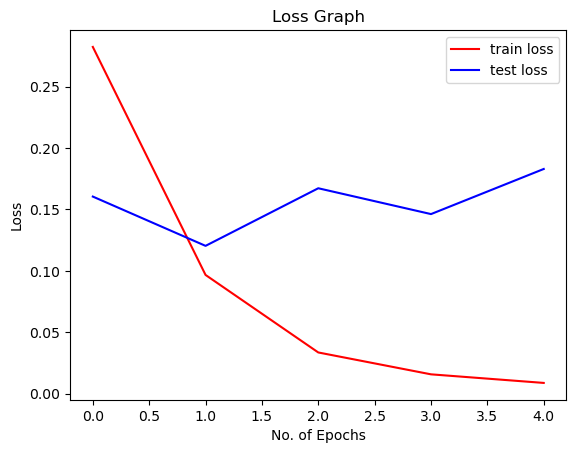

In [16]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

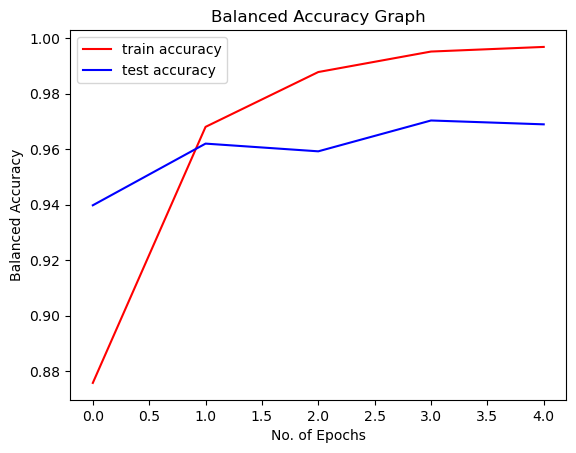

In [17]:
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

# Evaluation

In [18]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.spam))
print("Test Binary Crossentropy Loss:", loss)
print("Test Binary Accuracy:", acc)

57/57 [==============================] - 277s 5s/step - loss: 0.1829 - balanced_accuracy: 0.9689
Test Binary Crossentropy Loss: 0.18290454149246216
Test Binary Accuracy: 0.9688888788223267


In [19]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.spam,test_predictions))
print("Classification Report:")
print(classification_report(test_df.spam,test_predictions, digits=4))

57/57 [==============================] - 295s 5s/step
Confusion Matrix:
[[885  15]
 [ 39 861]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9578    0.9833    0.9704       900
           1     0.9829    0.9567    0.9696       900

    accuracy                         0.9700      1800
   macro avg     0.9703    0.9700    0.9700      1800
weighted avg     0.9703    0.9700    0.9700      1800



# Save Model

In [22]:
model.save('model/roberta_base.h5')